In [18]:
!pip install networkx osmnx matplotlib-venn matplotlib==3.1.1 ipyleaflet smart_mobility_utilities
!apt-get -qq install -y libfluidsynth1

     |████████████████████████████████| 3.3 MB 7.5 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=07a9e3f6f47586b28e7afc04d17d7de88a47553649759a131be98d5a9cbeab18
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


In [2]:
#import geopandas as gpd
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


ox.config(log_console=True, use_cache=True)

# find shortest route based on the mode of travel
mode      = 'drive'       # 'drive', 'bike', 'walk'
# find shortest path based on distance or time
optimizer = 'time'        # 'length','time'

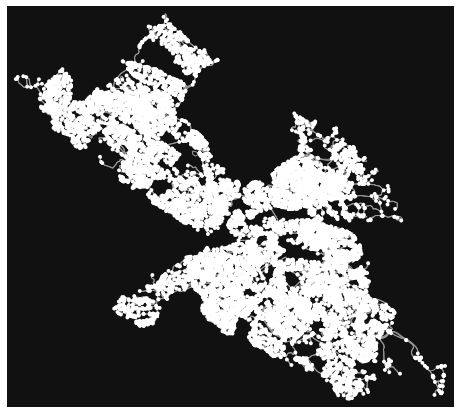

In [6]:
place ="Stockholm, Sweden"
G = ox.graph_from_place(place, network_type=mode)
fig, ax = ox.plot_graph(G)
fig.set_frameon(True)

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

Routing

In [4]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [11]:
# get the nearest network nodes to two lat/lng points
origin_point = ox.get_nearest_node(G, (59.37161087776124, 17.88536584751348))  
destination_point = ox.get_nearest_node(G, (59.369643061843455, 17.921285987723483)) 

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.


In [12]:
# find the shortest path
shortest_route = nx.shortest_path(G,
                                  origin_point,
                                  destination_point,
                                  weight=optimizer)
shortest_route_map = ox.plot_route_folium(G, shortest_route)
shortest_route_map

In [14]:
# find 10 shortest path with k_shortest_paths
routes = ox.k_shortest_paths(G, origin_point, destination_point, k=10, weight='length')
routes_list = list(routes)


rc = ['green','red','blue','gray','yellow','cyan','black','pink','purple','brown']
route_map = ox.plot_route_folium(G, routes_list[0], route_color=rc[0], opacity=0.5)
for i  in range(1,len(routes_list)):
  route_map = ox.plot_route_folium(G, routes_list[i], route_map=route_map, route_color=rc[i], opacity=0.5)

route_map.save('route.html')
route_map

/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be

In [16]:
# find 10 shortest path with all_shortest_paths
routs_all_shortest_paths = nx.all_shortest_paths(G, source=origin_point, target=destination_point)


rc = ['green','red','blue','gray','yellow','cyan']
routes = []
for path in routs_all_shortest_paths:
    routes.append(path)
route_map = ox.plot_route_folium(G, routes[0], route_color=rc[0], opacity=0.5)
for i  in range(1,len(routes)):
  route_map = ox.plot_route_folium(G, routes[i], route_map=route_map, route_color=rc[i], opacity=0.5)

route_map

/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead
/usr/local/lib/python3.7/dist-packages/osmnx/folium.py:126: UserWarning: `route_color` has been deprecated and will be removed: use kwargs instead


In [19]:
from smart_mobility_utilities.problem import astar_heuristic
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.viz import draw_route

In [20]:
def A_Star(G, origin, destination):
    toOrigin, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)
    route = []
    frontier = list()
    frontier.append(origin)
    explored = set()
    found = False
    while frontier and not found:   
        # choose a node based on its heuristic value
        node = min(frontier, key = lambda node : toOrigin[node.osmid] + toDestination[node.osmid])
        frontier.remove(node)
        explored.add(node)
        # expand its children
        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    found = True
                    continue
                frontier.append(child)
    return route

In [23]:
reference = (43.661667, -79.395) #59.32928067101834, 18.064704759157724
G = ox.graph_from_point(reference, dist=500, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=55808290)
destination = Node(graph=G, osmid=389677909)


route = A_Star(G, origin, destination)
print(f"Route: {route}")
# print(f"Cost: {cost(G,route)}")
# for i in range(len(a)):
draw_route(G,route)

Route: [55808290, 304891685, 1721866234, 9270977970, 3179025274, 9270977966, 389678267, 9270977960, 389678104, 9270977978, 9270977975, 1258698113, 389678151, 389678142, 2143489694, 389678141, 2143488528, 389678140, 389678139, 389678138, 3707407638, 6028561924, 6028561921, 389678131, 2557539841, 9517994073, 9517994074, 389677909]


Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…